In [ ]:
import os
import sys
import csv
import time
import chess
import chess.engine
import requests
import json
import pandas as pd
from dotenv import load_dotenv
from subprocess import Popen, PIPE, DEVNULL
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Constants
stockfish_exe = "/Users/saumik/Documents/classes/rotations/code/Stockfish/src/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_exe)
depth = 20
load_dotenv()   
token = os.getenv('LICHESS_TOKEN')

In [ ]:
def get_fens(player, max_games='null', token=None):
    headers = {'Accept':'application/x-ndjson'}
    if token:
        headers['Authorization'] = f'Bearer {token}'
    params = {'max':max_games, 'perfType':'blitz'}
    response = requests.get(f"https://lichess.org/api/games/user/{player}", headers=headers, params=params)
    with open(f'data/{player}.csv', 'w') as f:
        for line in response.iter_lines():
            line = json.loads(line.decode('utf-8'))
            if line['variant'] == 'standard' and 'moves' in line:
                try:
                    color = 'w' if line['players']['white']['user']['name'] == player else 'b'
                except:
                    continue
                moves = line['moves'].split()
                board = chess.Board()
                for san in moves:
                    uci = board.parse_san(san).uci()
                    fen = board.fen()
                    movenum = int(fen.split()[5])
                    if fen.split()[1] == color and movenum >= 10 and movenum < 30:
                        print(f'{uci},{fen}', file=f)
                    board.push_uci(uci)

In [ ]:
players_to_download = ['Konevlad','Crecent','LongLive16Hayastan','may6enexttime','IWANNABEADOORED',
                       'Ogrilla','dolar9','MilfSalvatore','cutemouse83','Benefactorr',
                       'cjota95','alireza2003','vistagausta','GRUrussia','Drvitman',
                       'NIndja64','KnezMihailova','Bestinblitz','AnonLondonKiller','black_knight22',
                       'IVK88','Inventing_Invention','temp006','Arka50','Ernst_Gruenfeld',
                       'Zaola420','GeorgMeier','SindarovGM','BenjaminBokTwitch','Hungry_Dragon',
                       'avantage_ru','Chesstoday','GABUZYAN_CHESSMOOD','Tryhard00','TilChess',
                       'muisback','MikeGScarn','Zhalmakhanov_R','L04d1ng','BabaRamdev',
                       'opperwezen','Feokl1995','LucaBrazzi','Venost17','RebeccaHarris',
                       'gmmoranda','YuQuesada','FakeBruceLee','swimmerchess','GrigorGrigorov']

In [ ]:
# for p in tqdm(players_to_download):
#     get_fens(p, max_games=100, token=token)

In [ ]:
def clean_score(score):
    score = round(float(score),2)
    score = 2.0 if score > 2 else score
    score = -2.0 if score < -2 else score
    return score

def evaluate(fen, next_move=None):
    process = Popen(stockfish_exe, shell=True, stdin=PIPE, stdout=PIPE, stderr=DEVNULL)
    if next_move:
        output = process.communicate(input=str.encode(f"position fen {fen} moves {next_move}\neval\n"))[0]
    else:
        output = process.communicate(input=str.encode(f"position fen {fen}\neval\n"))[0]
    if process.returncode != 0:
        sys.stderr.write(f"Failed: {stockfish_exe}\n")
        sys.exit(1)

    # parse for parameter output
    components = ['Material','Imbalance','Mobility','King safety','Threats','Passed','Space','Winnable']
    scores = []
    for line in output.decode("utf-8").split("\n"):
        if any(c in line for c in components):
            mg_score = line.split('|')[3].split()[0]
            mg_score = clean_score(mg_score)
            scores.append(mg_score)
    return tuple(scores)

In [ ]:
# Unused at the moment
def get_next_states(fen):
    board = chess.Board(fen)
    moves = [move.uci() for move in board.legal_moves]
    states = set()
    for move in tqdm(moves):
        scores = evaluate(fen, move)
        if scores != ():
            states.add(scores)
    return states

In [8]:
def get_best_move(fen):
#     print(fen)
    board = chess.Board(fen=fen)
    info = engine.analyse(board, chess.engine.Limit(depth=20))
    return info['pv'][0]

In [9]:
def rm_paren(tup):
    if tup == ():
        return ',,,,,,,'
    return ','.join(str(i) for i in tup)

In [10]:
def get_avg_bias(player):    
    num_lines = sum(1 for line in open(f'data/{player}.csv','r'))
    with open(f'data/{player}.csv', 'r') as f:
        with open(f'diffs/{player}.csv','w') as fw:
            csv_reader = csv.reader(f, delimiter=',')
#             count = 0
            for uci,fen in tqdm(csv_reader, total=num_lines):
#                 if count >= 10:
#                     break
                current_eval = evaluate(fen)
                played_eval = evaluate(fen, uci)
                best = get_best_move(fen)
                best_eval = played_eval if str(best) == str(uci) else evaluate(fen, best)
                print(f'{fen},{rm_paren(current_eval)},{uci},{rm_paren(played_eval)},{best},{rm_paren(best_eval)}', file=fw)
#                 count+=1

In [11]:
# for p in players_to_download:
#     print(f'Starting {p}')
#     time.sleep(1)
#     get_avg_bias(p)
#     time.sleep(1)

In [12]:
def get_df(filename, cols, names):
    df = pd.read_csv(filename, names=names, index_col=False, usecols=['fen']+cols)
    df['color'] = df['fen'].apply(lambda x: x.split()[1])
    df = df.drop('fen', axis=1)
    df.loc[df['color'] == 'b',cols] = df*-1
    df = df.drop('color', axis=1)
    return df

In [13]:
def calc_bias(diffs_file):
    elen = 8
    fen_cols = [f'f{i}' for i in range(elen)]
    player_cols = [f'p{i}' for i in range(elen)]
    best_cols = [f'b{i}' for i in range(elen)]
    names = ['fen'] + fen_cols + ['player'] + player_cols + ['best'] + best_cols
    # skiprows = lambda x: x.split()[1] == 'b'

    df_fen = get_df(diffs_file, fen_cols, names)
    df_player = get_df(diffs_file, player_cols, names)
    df_best = get_df(diffs_file, best_cols, names)
    
    df_player_change = df_player - df_fen.values
    df_best_change = df_best - df_fen.values
    df_player_bias = df_player - df_best.values
    
    return df_player_change.mean(), df_best_change.mean(), df_player_bias.mean()

In [14]:
ans = [calc_bias(f'diffs/{i}.csv') for i in players_to_download]

pchange = pd.concat([i[0] for i in ans], axis=1).T
bchange = pd.concat([i[1] for i in ans], axis=1).T
pbias = pd.concat([i[2] for i in ans], axis=1).T

In [15]:
pchange

,p0,p1,p2,p3,p4,p5,p6,p7
0,0.448433,0.094082,0.069552,0.137933,0.130660,0.028714,0.025362,-0.000930
1,0.458497,0.093217,0.068781,0.180133,0.133011,0.032511,0.030060,-0.000597
2,0.388387,0.091501,0.066009,0.141961,0.175243,0.034545,0.023917,-0.000959
3,0.397801,0.089261,0.068063,0.150219,0.164360,0.034267,0.022352,0.000016
4,0.412359,0.090588,0.068874,0.145730,0.148394,0.030894,0.026092,-0.001012
5,0.421403,0.096962,0.059163,0.099026,0.127727,0.039862,0.026483,-0.000297
6,0.466023,0.105148,0.066822,0.145790,0.144040,0.030201,0.026746,0.000214
7,0.385017,0.091729,0.071787,0.141781,0.152055,0.032584,0.028650,-0.000070
8,0.411956,0.089609,0.068511,0.129054,0.154588,0.030981,0.021173,-0.000683
9,0.411229,0.089956,0.071051,0.212654,0.149975,0.032356,0.029823,0.000000


In [16]:
bchange

,b0,b1,b2,b3,b4,b5,b6,b7
0,0.451168,0.097445,0.071711,0.145266,0.119301,0.022133,0.024728,-0.001272
1,0.475632,0.097915,0.079317,0.183853,0.136303,0.036645,0.034386,-0.000276
2,0.400553,0.096012,0.065758,0.140640,0.164602,0.035106,0.029584,-0.001012
3,0.407909,0.094012,0.073181,0.148982,0.144518,0.030864,0.024315,0.000017
4,0.408619,0.090352,0.069255,0.139630,0.154866,0.027010,0.026788,-0.000898
5,0.410401,0.095854,0.061864,0.106984,0.138125,0.040801,0.028559,-0.000017
6,0.438403,0.093838,0.060568,0.132753,0.151736,0.030013,0.027285,0.000278
7,0.370374,0.086996,0.072519,0.132496,0.163641,0.036587,0.029001,-0.000047
8,0.422949,0.097985,0.069548,0.131498,0.138737,0.023901,0.021298,-0.000635
9,0.423111,0.090483,0.067595,0.214332,0.154720,0.030833,0.033397,0.000000


In [17]:
pbias

,p0,p1,p2,p3,p4,p5,p6,p7
0,-0.007226,-0.004243,-0.002407,-0.006819,0.013723,5.457627e-03,0.000825,0.000040
1,-0.020568,-0.005509,-0.010012,-0.001941,-0.002219,-5.124260e-03,-0.004266,-0.000314
2,-0.011761,-0.004300,0.000404,0.000287,0.012251,-5.015291e-04,-0.005291,0.000080
3,-0.014099,-0.004654,-0.004510,0.003369,0.022740,4.061834e-03,-0.002175,0.000000
4,0.001752,-0.000628,0.000306,0.005595,-0.007859,2.936596e-03,-0.000628,-0.000117
5,0.011450,0.001564,-0.002215,-0.004050,-0.010755,-2.442997e-04,-0.001868,-0.000277
6,0.026378,0.009726,0.005999,0.006092,-0.006640,9.769757e-04,-0.000473,-0.000062
7,0.018285,0.004764,-0.000262,0.010006,-0.011499,-3.339031e-03,-0.000239,-0.000023
8,-0.006464,-0.006933,-0.001699,-0.001814,0.014661,6.162319e-03,-0.000342,0.000000
9,-0.009410,0.000174,0.005031,0.002360,-0.002149,8.509317e-04,-0.003410,0.000000


[0.68683084 0.17240658]


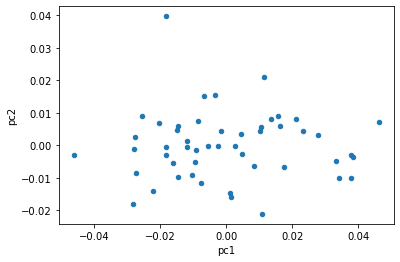

In [18]:
x_orig = pbias
pca_orig = PCA(n_components=2).fit(x_orig)
df_orig = pd.DataFrame(data=pca_orig.transform(x_orig),
                       columns = ['pc1','pc2'])
print(pca_orig.explained_variance_ratio_)
df_orig.plot.scatter(x='pc1',y='pc2')

[0.40238226 0.18663767]


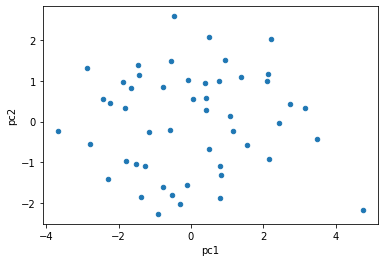

In [19]:
x_scal = StandardScaler().fit_transform(pbias)
pca_scal = PCA(n_components=2).fit(x_scal)
df_scal = pd.DataFrame(data=pca_scal.transform(x_scal),
                       columns = ['pc1','pc2'])
print(pca_scal.explained_variance_ratio_)
df_scal.plot.scatter(x='pc1',y='pc2')